# Installations

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.4 MB/s eta 0:00:00


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.1 MB/s eta 0:00:00


# Imports

In [3]:
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import optuna

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn import tree
from sklearn.metrics import fbeta_score, make_scorer
import shap

# Reading in the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
bank = pd.read_csv('drive/MyDrive/COMP3820/project/store/clean_store.csv')
predictors = list(bank.columns[:-1])
bank = bank[predictors]

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='resp']
X_valid = valid.loc[:, test.columns!='resp']
X_test = test.loc[:, test.columns!='resp']

# predictors = list(X_train.columns)

y_train = train['resp']
y_valid = valid['resp']
y_test = test['resp']

In [6]:
X_train

,zip_code,fre,mon,cc_card,avrg,pc_calc20,psweaters,pknit_tops,pknit_dres,pblouses,...,styles,stores,web,mailed,responded,responserate,hi,ltfreday,clustype,percret
19843,85032,13,867.27,1,66.71,16,0.47,0.02,0.04,0.00,...,42,2,0,9,5,55.56,25.34,13.46,22,0.36
812,7109,2,138.54,1,69.27,16,0.15,0.00,0.00,0.16,...,8,4,0,2,0,0.00,9.76,9.75,10,0.44
2533,19073,1,232.98,0,232.98,16,0.06,0.00,0.00,0.12,...,5,2,0,1,0,0.00,41.66,86.50,10,0.00
10857,48393,6,191.95,0,31.99,15,0.29,0.03,0.20,0.00,...,9,4,0,1,1,100.00,25.13,47.23,4,0.00
9135,44406,7,1327.65,0,189.66,16,0.25,0.04,0.01,0.08,...,36,4,0,2,1,50.00,17.11,7.53,4,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17679,74701,5,1155.22,0,231.04,18,0.44,0.00,0.00,0.20,...,43,5,0,5,1,20.00,28.04,23.66,40,0.00
15909,64468,2,136.07,1,68.03,11,0.00,0.00,0.16,0.24,...,7,2,0,5,1,20.00,27.95,160.50,10,0.00
3396,22204,3,132.97,0,44.32,11,0.28,0.00,0.00,0.00,...,4,2,0,2,0,0.00,29.78,80.50,12,0.00
7927,38139,4,269.49,0,67.37,11,0.45,0.00,0.00,0.23,...,9,2,0,8,2,25.00,32.48,98.85,1,0.00


# Transforming the continuous data

In [7]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00


# Confusion matrix code

In [8]:
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total subscribed Transactions: ', np.sum(cm[1]))

# Benchmark decision tree without any tuning with best encodings

In [9]:
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score
def get_model_performance(algo, feature_list, algo_name):

  X_train = train[feature_list]
  X_test = test[feature_list]
  model = algo
  model.fit(X_train, y_train)

  # validation set predictions
  y_prob = np.zeros(len(y_test))
  y_prob = model.predict_proba(X_test)[:, 1]

  lfp = 1
  lfn = 19
  tau = lfp/(lfp+lfn)

  y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
  y_prob[y_prob > 1- 1e-5] =  1- 1e-5

  y_pred = (y_prob > tau).astype(int)
  # y_pred = model.predict(X_valid)
        
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

  columns=['Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision', 'F1-score']

  results = pd.DataFrame(0.0, columns=columns, index=[algo_name])

  results.iloc[:,0] =  log_loss(y_test, y_prob)   # Cross entropy
  results.iloc[:,1] =   1 - accuracy_score(y_test, y_pred)   # Error rate
  results.iloc[:,2] =  roc_auc_score(y_test, y_prob)   # AUC
  results.iloc[:,3] =  tp/(tp+fn)   # Sensitivity 
  results.iloc[:,4] =  tn/(tn+fp)   # Specificity	
  results.iloc[:,5] =  precision_score(y_test, y_pred)   # Precision
  results.iloc[:,6] =  f1_score(y_test, y_pred)  #f1-score
  return results, model

decision_tree = tree.DecisionTreeClassifier(random_state=42)
results, fitted_model = get_model_performance(decision_tree, X_train.columns, "Decision Tree")

display(results.sort_values(by=['F1-score'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Decision Tree,2.39684,0.20819,0.63874,0.40724,0.87025,0.39029,0.39858


(True Negatives):  2224
(False Positives):  298
(False Negatives):  304
(True Positives):  218
Total subscribed Transactions:  522


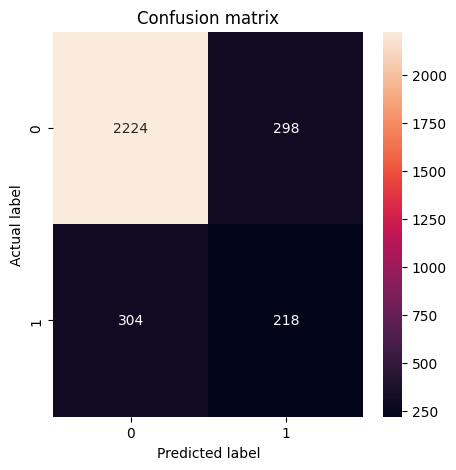

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = decision_tree.predict_proba(X_valid[X_train.columns])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

In [ ]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 40)
    max_features = trial.suggest_int('max_features', 1, 39)
    
    
    model = tree.DecisionTreeClassifier(random_state=42, criterion = criterion, max_features = max_features, min_samples_leaf= min_samples_leaf)
  
    scores = cross_val_score(model, train[X_train.columns], y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 120) 

[I 2023-05-23 11:42:25,717] A new study created in memory with name: no-name-261fa385-3211-400f-aabf-ddf688753d32
[I 2023-05-23 11:42:26,610] Trial 0 finished with value: 0.41300356217043327 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_features': 24}. Best is trial 0 with value: 0.41300356217043327.
[I 2023-05-23 11:42:28,157] Trial 1 finished with value: 0.3617174869710337 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 3, 'max_features': 34}. Best is trial 0 with value: 0.41300356217043327.
[I 2023-05-23 11:42:29,536] Trial 2 finished with value: 0.3604119732739054 and parameters: {'criterion': 'gini', 'min_samples_leaf': 1, 'max_features': 38}. Best is trial 0 with value: 0.41300356217043327.
[I 2023-05-23 11:42:29,840] Trial 3 finished with value: 0.3719515105897225 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 8, 'max_features': 8}. Best is trial 0 with value: 0.41300356217043327.
[I 2023-05-23 11:42:30,140] Trial 4 finished with v

In [ ]:
params = study.best_params
params

{'criterion': 'entropy', 'min_samples_leaf': 26, 'max_features': 38}

In [ ]:
params

{'criterion': 'entropy', 'min_samples_leaf': 26, 'max_features': 38}

In [ ]:
feature_for_dt = X_train.columns

In [ ]:
decision_tree = tree.DecisionTreeClassifier(random_state=42, **params)
results, dt_model = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Decision Tree,0.52675,0.34616,0.79198,0.82262,0.61942,0.30596,0.44603


In [ ]:
decision_tree = tree.DecisionTreeClassifier(random_state=42, **params, max_depth=2)
results, dt_model = get_model_performance(decision_tree, feature_for_dt, "Decision Tree")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Decision Tree,0.35818,0.39491,0.80025,0.91312,0.54227,0.28919,0.43927


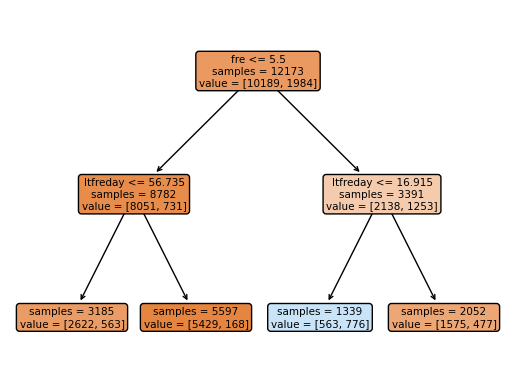

In [ ]:
from sklearn.tree import plot_tree

plot_tree(dt_model, feature_names = feature_for_dt, impurity=False,
          rounded=True, filled = True)
plt.show()

(True Negatives):  1413
(False Positives):  1109
(False Negatives):  40
(True Positives):  482
Total subscribed Transactions:  522


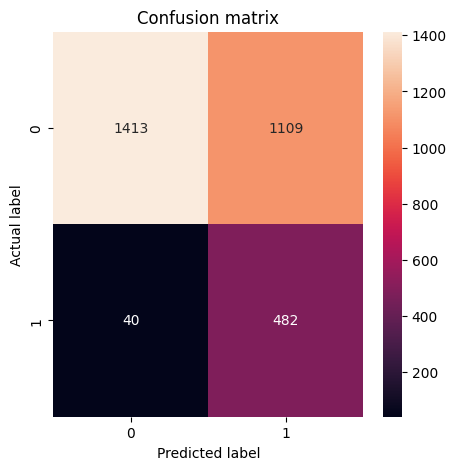

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = decision_tree.predict_proba(X_valid[feature_for_dt])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_valid, y_pred)

# Decision tree on test set

(True Negatives):  2938
(False Positives):  2480
(False Negatives):  96
(True Positives):  1009
Total subscribed Transactions:  1105


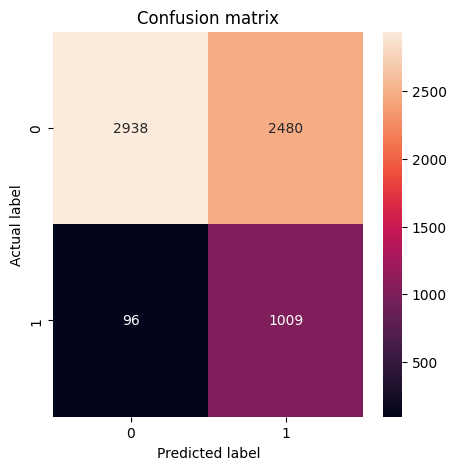

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = decision_tree.predict_proba(test[feature_for_dt])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)
# y_pred = decision_tree.predict(valid[feature_for_dt])

plot_cm(y_test, y_pred)

# Random Forest without tuning

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
feature_for_rf = X_train.columns
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
results, fitted_model = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Random Forest,0.35304,0.50069,0.82613,0.94751,0.4079,0.24606,0.39067


In [12]:
num_features_rf = len(feature_for_rf)
num_features_rf

46

In [ ]:

def objective(trial):
    
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 40)
    max_features = trial.suggest_int('max_features', 1, num_features_rf)
    max_depth = trial.suggest_int('max_depth', 1, 40)
    
    
    model = RandomForestClassifier(n_estimators = 100,  
                                  criterion = criterion,  
                                  max_features = max_features, 
                                  min_samples_leaf= min_samples_leaf,
                                  max_depth=max_depth,
                                  random_state = 42)
  
    scores = cross_val_score(model, X_train[feature_for_rf], y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

[I 2023-05-23 11:44:33,140] A new study created in memory with name: no-name-b414638a-4351-4342-81cb-c9161ccd266b
[I 2023-05-23 11:45:11,029] Trial 0 finished with value: 0.3862286325490087 and parameters: {'criterion': 'gini', 'min_samples_leaf': 30, 'max_features': 28, 'max_depth': 7}. Best is trial 0 with value: 0.3862286325490087.
[I 2023-05-23 11:45:46,608] Trial 1 finished with value: 0.39433507567323633 and parameters: {'criterion': 'entropy', 'min_samples_leaf': 35, 'max_features': 28, 'max_depth': 29}. Best is trial 1 with value: 0.39433507567323633.
[I 2023-05-23 11:45:58,448] Trial 2 finished with value: 0.34565763121564624 and parameters: {'criterion': 'gini', 'min_samples_leaf': 34, 'max_features': 10, 'max_depth': 8}. Best is trial 1 with value: 0.39433507567323633.
[I 2023-05-23 11:46:25,807] Trial 3 finished with value: 0.3841621698542089 and parameters: {'criterion': 'gini', 'min_samples_leaf': 21, 'max_features': 20, 'max_depth': 12}. Best is trial 1 with value: 0.394

KeyboardInterrupt: ignored

In [ ]:
params = study.best_params
params

In [13]:
params = {'criterion': 'gini', 'min_samples_leaf': 40, 'max_features': 30}

In [ ]:
params = {'criterion': 'entropy',
 'min_samples_leaf': 40,
 'max_features': 43,
 'max_depth': 25}

In [14]:
feature_for_rf = X_train.columns

In [15]:
random_forest = RandomForestClassifier(**params, n_estimators = 1000,
                                        random_state = 42)
results, fitted_model = get_model_performance(random_forest, feature_for_rf, "Random Forest")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision,F1-score
Random Forest,0.32883,0.45853,0.8506,0.96018,0.45607,0.26472,0.41502


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


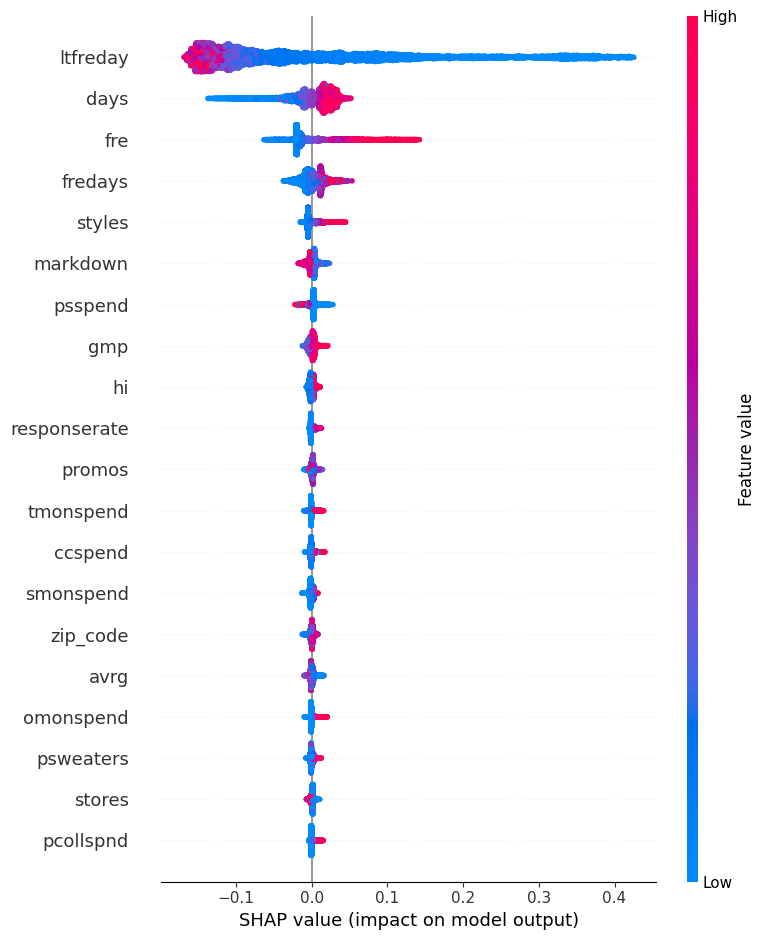

In [16]:
shap.initjs()

explainer = shap.Explainer(fitted_model)
shap_values = explainer.shap_values(test[feature_for_rf])
shap.summary_plot(shap_values[1], test[feature_for_rf])

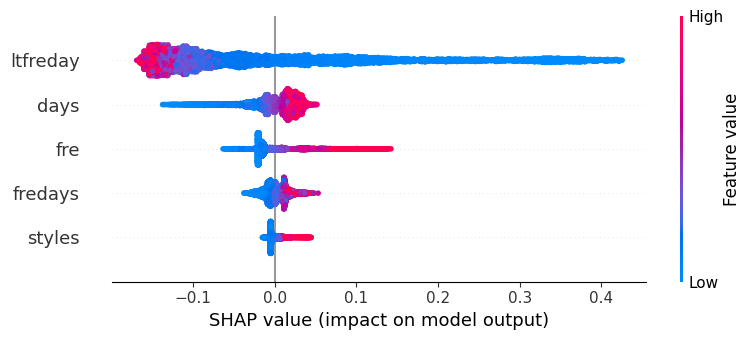

In [17]:
shap.summary_plot(shap_values[1], test[feature_for_rf], max_display=5)

# Confusion matrix for random forest

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = random_forest.predict_proba(valid[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = random_forest.predict_proba(X_test[feature_for_rf])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_test, y_pred)

# Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
feature_for_bag = X_train.columns

In [ ]:
base_bag = BaggingClassifier(tree.DecisionTreeClassifier(criterion='entropy'), n_estimators=100, random_state=42)

results, fitted_model = get_model_performance(base_bag, feature_for_bag, "Bagging with trees")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = base_bag.predict_proba(X_valid[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = base_bag.predict_proba(X_test[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_test, y_pred)

In [ ]:
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
def objective(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 2, 200)
    max_samples = trial.suggest_int('max_samples', 1, 2000)
    max_features = trial.suggest_int('max_features', 1, len(X_train.columns))
    
    
    model = BaggingClassifier(n_estimators = n_estimators,  
                                  max_samples= max_samples,
                                  max_features=max_features,
                                  random_state = 42)
  
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1')
    loss = np.mean(scores)
    
    return loss

sampler = TPESampler(seed=42) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials = 1000, timeout = 2000) 

In [ ]:

params = study.best_params

In [ ]:
params

In [ ]:
tuned_bag = BaggingClassifier(**params, random_state=42)

results, fitted_model = get_model_performance(tuned_bag, feature_for_bag, "Bagging")

display(results.sort_values(by=['AUC'], ascending = [0]).round(5))

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = tuned_bag.predict_proba(valid[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_valid, y_pred)

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# y_pred = decision_tree.predict(X_valid[feature_for_dt])
y_prob = tuned_bag.predict_proba(X_test[feature_for_bag])
y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
y_prob[y_prob > 1- 1e-5] =  1- 1e-5

y_pred = (y_prob[:, 1] > tau).astype(int)

plot_cm(y_test, y_pred)